In [1]:
import os
import sys
import pylab as p
import pylab as pl
import matplotlib as mpl
import pylab as pl
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import r2_score
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as ticker
sns.reset_defaults()
import warnings
warnings.filterwarnings('ignore')

# Settings for matplotlib
plt.rcParams["font.family"] = "Arial"
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['pdf.fonttype'] = 42


In [2]:
# Dependency Function Definitions:
def calc_rmsd(x, y):
    if len(x) == 0:
        return 0.0
    chi2 = sum((y - x) ** 2)
    rmsd = np.sqrt(chi2 / len(y))
    return rmsd

def calc_r2(x, y):
    if len(x) == 0:
        return 0.0
    correlation = np.corrcoef(y, x)[0,1]**2
    return correlation

def diff(list1, list2):
    c = set(list1).union(set(list2))  # or c = set(list1) | set(list2)
    d = set(list1).intersection(set(list2))  # or d = set(list1) & set(list2)
    common = []
    for element in list1:
        if element in list2:
            common.append(element)
    return list(c - d), common

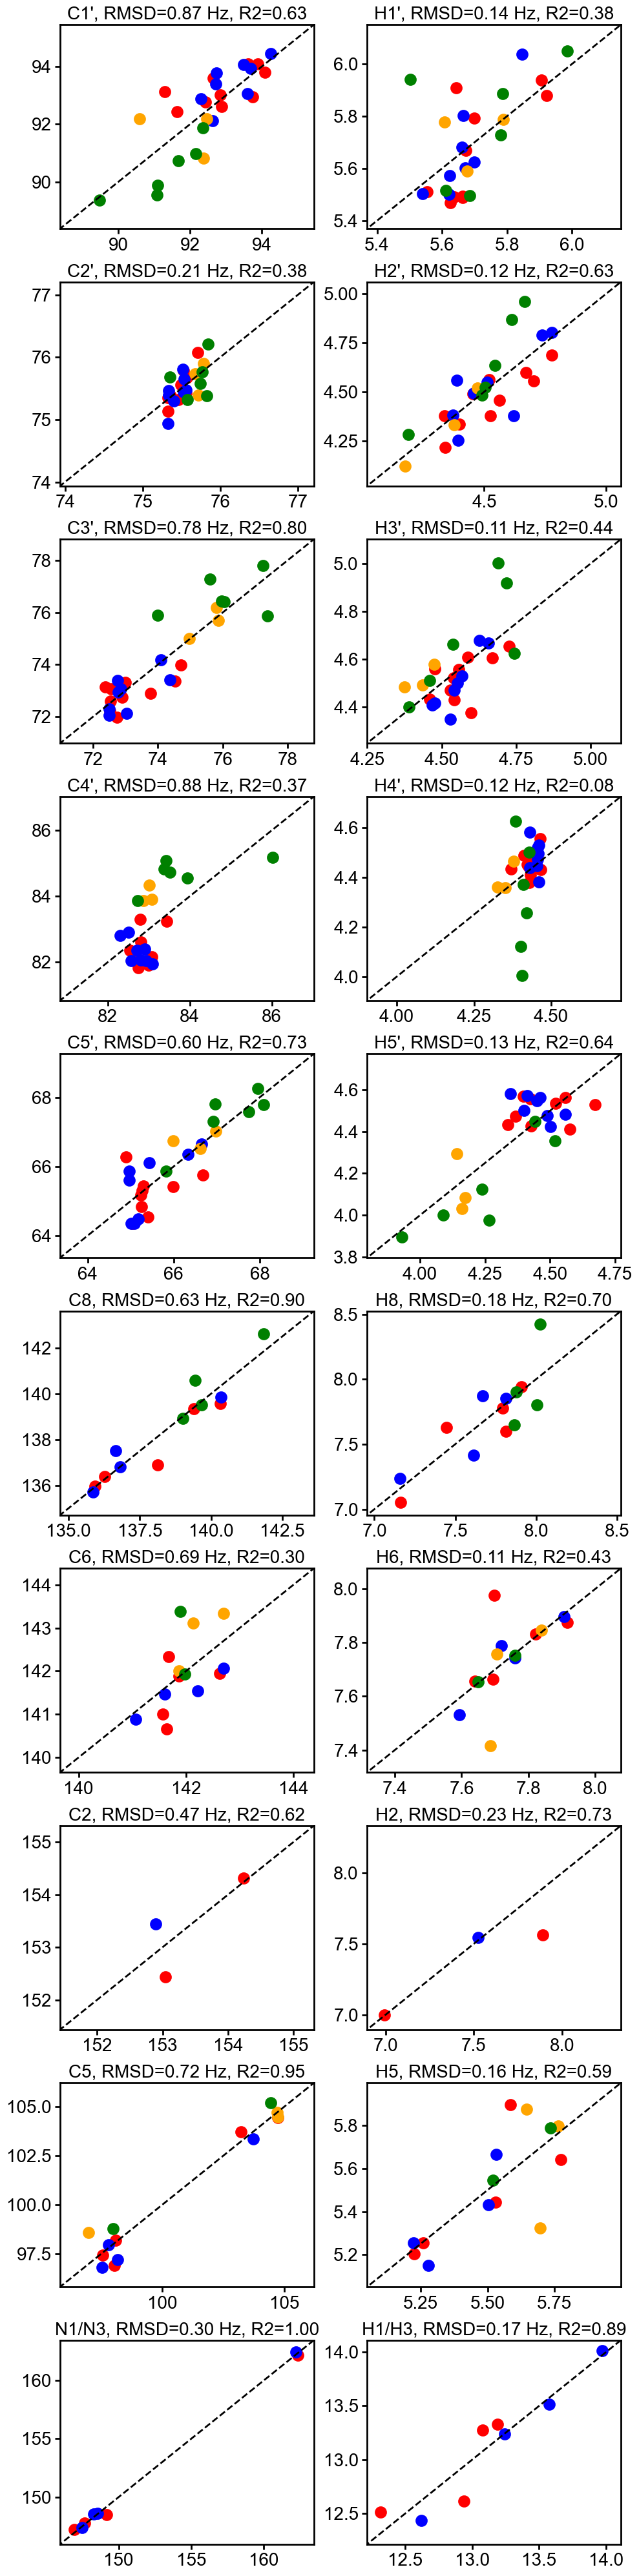

In [3]:
# FARFAR-NMR (lowest RMSD)

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/wtTAR_GS_ES1G34syn_Unbiased_LowestRMSD_DFT.csv").drop_duplicates()
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
dfp['shift_ens_avg'] = np.mean(dfp.iloc[:,2:], axis=1)
dfp['shift_ens_std'] = np.std(dfp.iloc[:,2:], axis=1)
dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
    'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
df = dfm.merge(dfp, on=["res", "atom"], how="inner")

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B', 'L']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L':'green'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    # Calculate linear correction:
    x = df.loc[filter1]["shift_ens_avg"]
    y = df.loc[filter1]["shift_nmr_avg"]
    m, b = np.polyfit(x, y, 1)   
    #print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
    x_H = df.loc[filter2]["shift_ens_avg"]
    y_H = df.loc[filter2]["shift_nmr_avg"]
    m_H, b_H = np.polyfit(x_H, y_H, 1)   
    #print(resonance_H , ": y = %3.2f x + %3.2f"%(m_H, b_H))
    
    # Set up limits of axes
    lim_up = max(np.max(y), np.max(x*m+b)) + 1
    lim_down = min(np.min(y), np.min(x*m+b)) - 1
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    lim_up = max(np.max(y_H), np.max(x_H*m_H+b_H)) + 0.1
    lim_down = min(np.min(y_H), np.min(x_H*m_H+b_H)) - 0.1
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # Plot heavy atom:
        df_f = df.loc[(mask[domain]) & (filter1)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m * df_f.shift_ens_avg + b, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        # Plot proton associated with it:
        df_f = df.loc[(mask[domain]) & (filter2)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H * df_f.shift_ens_avg + b_H, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    x=np.array(x)
    y=np.array(y)
    x_H = np.array(x_H)
    y_H = np.array(y_H)
 
    R2 = calc_r2(m*x+b, y)
    RMSD = calc_rmsd(m*x+b, y)
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
    R2_H = calc_r2(m_H*x_H+b_H, y_H)
    RMSD_H = calc_rmsd(m_H*x_H+b_H, y_H)
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD_H, R2_H), fontsize=20)
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
#plt.savefig("plots/FARFAR_NMR_LowestRMSD_Ensemble_DFT.pdf")
plt.show()

C1' : y = 1.04 x + -8.88
C2' : y = 0.25 x + 55.77
C3' : y = 1.09 x + -7.09
C4' : y = 0.53 x + 39.99
C5' : y = 0.58 x + 26.62
C8 : y = 0.95 x + 13.41
C6 : y = 0.74 x + 39.99
C2 : y = 0.49 x + 79.28
C5 : y = 0.59 x + 42.19
N1/N3 : y = 0.61 x + 52.95


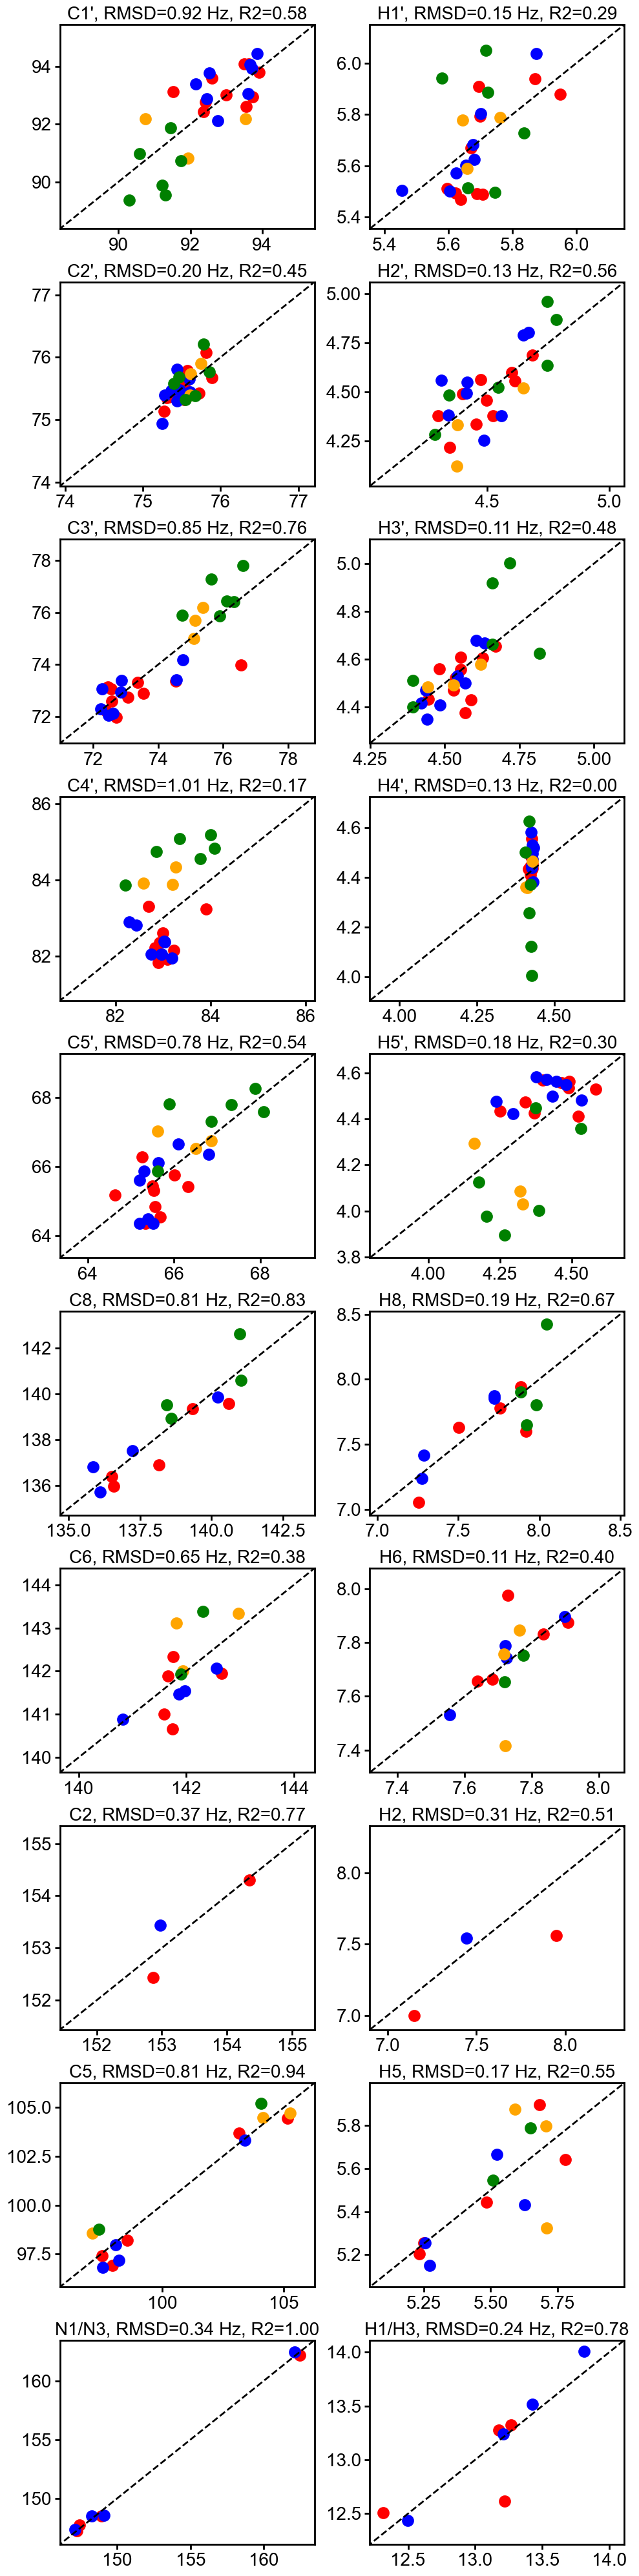

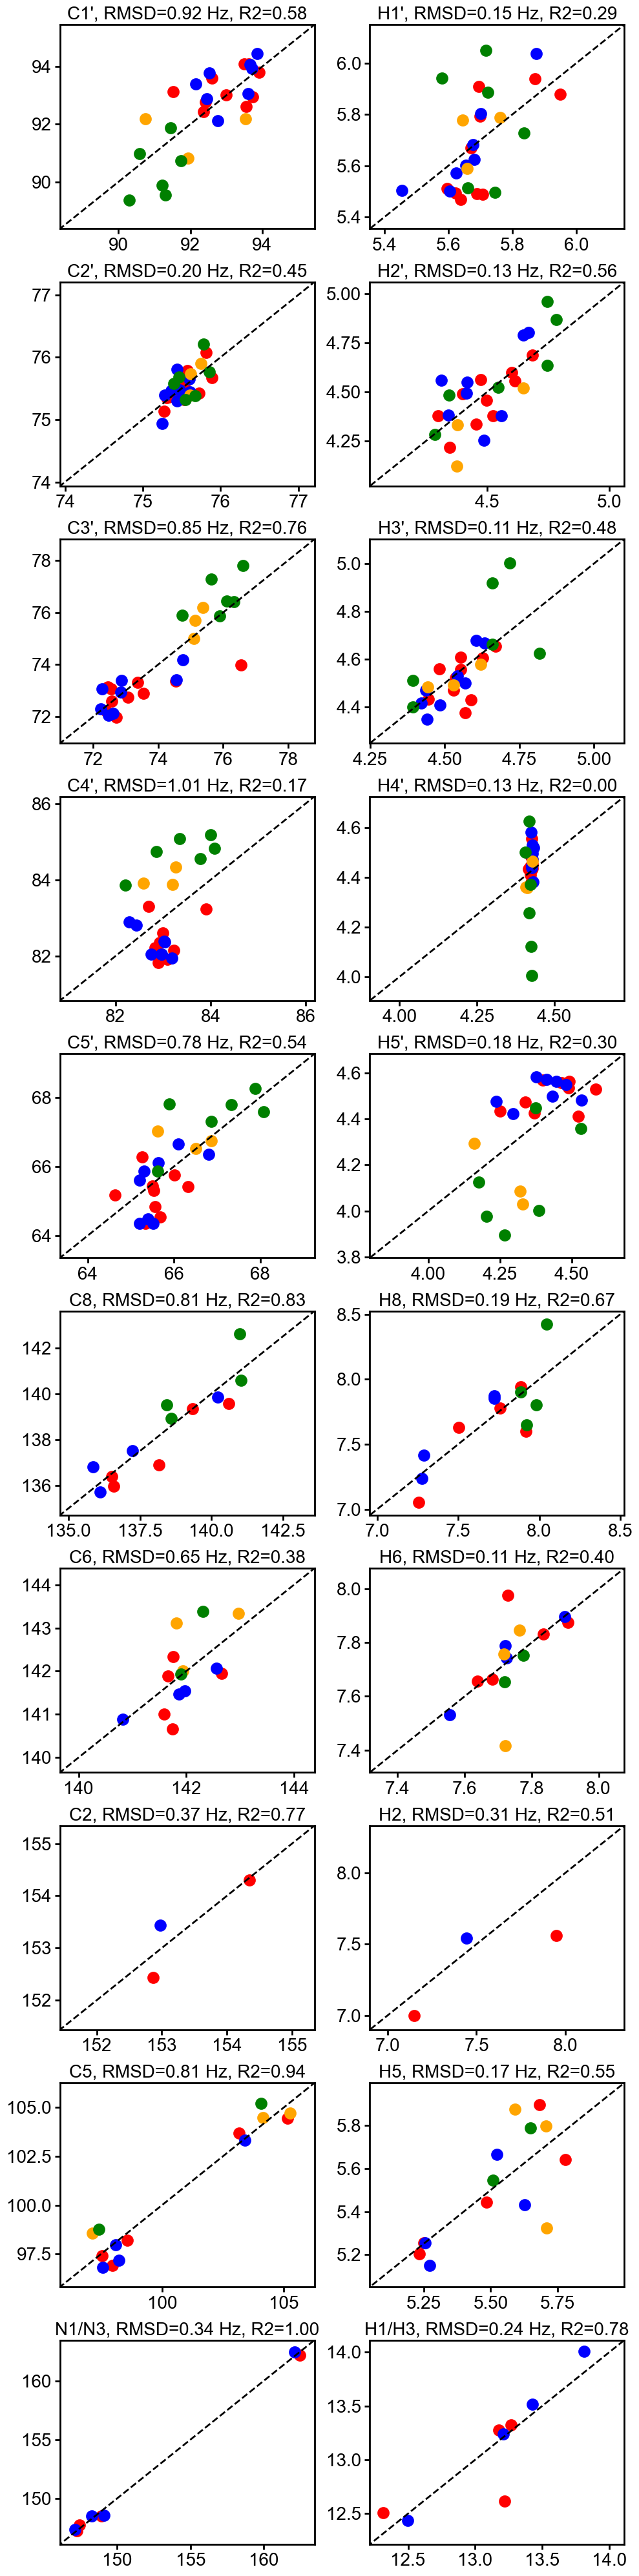

In [5]:
# FARFAR-NMR random (Library)

# Read in CSV data
dfp = pd.read_csv("data/FARFAR-wt-TAR-PoolRandom_predictedCS.csv").drop_duplicates()
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
dfp['shift_ens_avg'] = np.mean(dfp.iloc[:,2:], axis=1)
dfp['shift_ens_std'] = np.std(dfp.iloc[:,2:], axis=1)
dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
    'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
df = dfm.merge(dfp, on=["res", "atom"], how="inner")

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B', 'L']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L':'green'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    # Calculate linear correction:
    x = df.loc[filter1]["shift_ens_avg"]
    y = df.loc[filter1]["shift_nmr_avg"]
    m, b = np.polyfit(x, y, 1)   
    print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
    x_H = df.loc[filter2]["shift_ens_avg"]
    y_H = df.loc[filter2]["shift_nmr_avg"]
    m_H, b_H = np.polyfit(x_H, y_H, 1)   
    #print(resonance_H , ": y = %3.2f x + %3.2f"%(m_H, b_H))
    
    # Set up limits of axes
    lim_up = max(np.max(y), np.max(x*m+b)) + 1
    lim_down = min(np.min(y), np.min(x*m+b)) - 1
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    lim_up = max(np.max(y_H), np.max(x_H*m_H+b_H)) + 0.1
    lim_down = min(np.min(y_H), np.min(x_H*m_H+b_H)) - 0.1
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # Plot heavy atom:
        df_f = df.loc[(mask[domain]) & (filter1)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m * df_f.shift_ens_avg + b, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        # Plot proton associated with it:
        df_f = df.loc[(mask[domain]) & (filter2)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H * df_f.shift_ens_avg + b_H, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    x=np.array(x)
    y=np.array(y)
    x_H = np.array(x_H)
    y_H = np.array(y_H)
 
    R2 = calc_r2(m*x+b, y)
    RMSD = calc_rmsd(m*x+b, y)
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
    R2_H = calc_r2(m_H*x_H+b_H, y_H)
    RMSD_H = calc_rmsd(m_H*x_H+b_H, y_H)
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD_H, R2_H), fontsize=20)
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
#plt.savefig("plots/FARFAR_Random_Ensemble_DFT.pdf")
plt.show()

C1' : y = 0.92 x + 1.34
C2' : y = 0.19 x + 60.56
C3' : y = 0.41 x + 42.62
C4' : y = -0.25 x + 103.91
C5' : y = 0.50 x + 31.88
C8 : y = 0.91 x + 17.50
C6 : y = 0.12 x + 124.95
C2 : y = 0.35 x + 99.59
C5 : y = 0.62 x + 38.24
N1/N3 : y = 0.60 x + 53.51


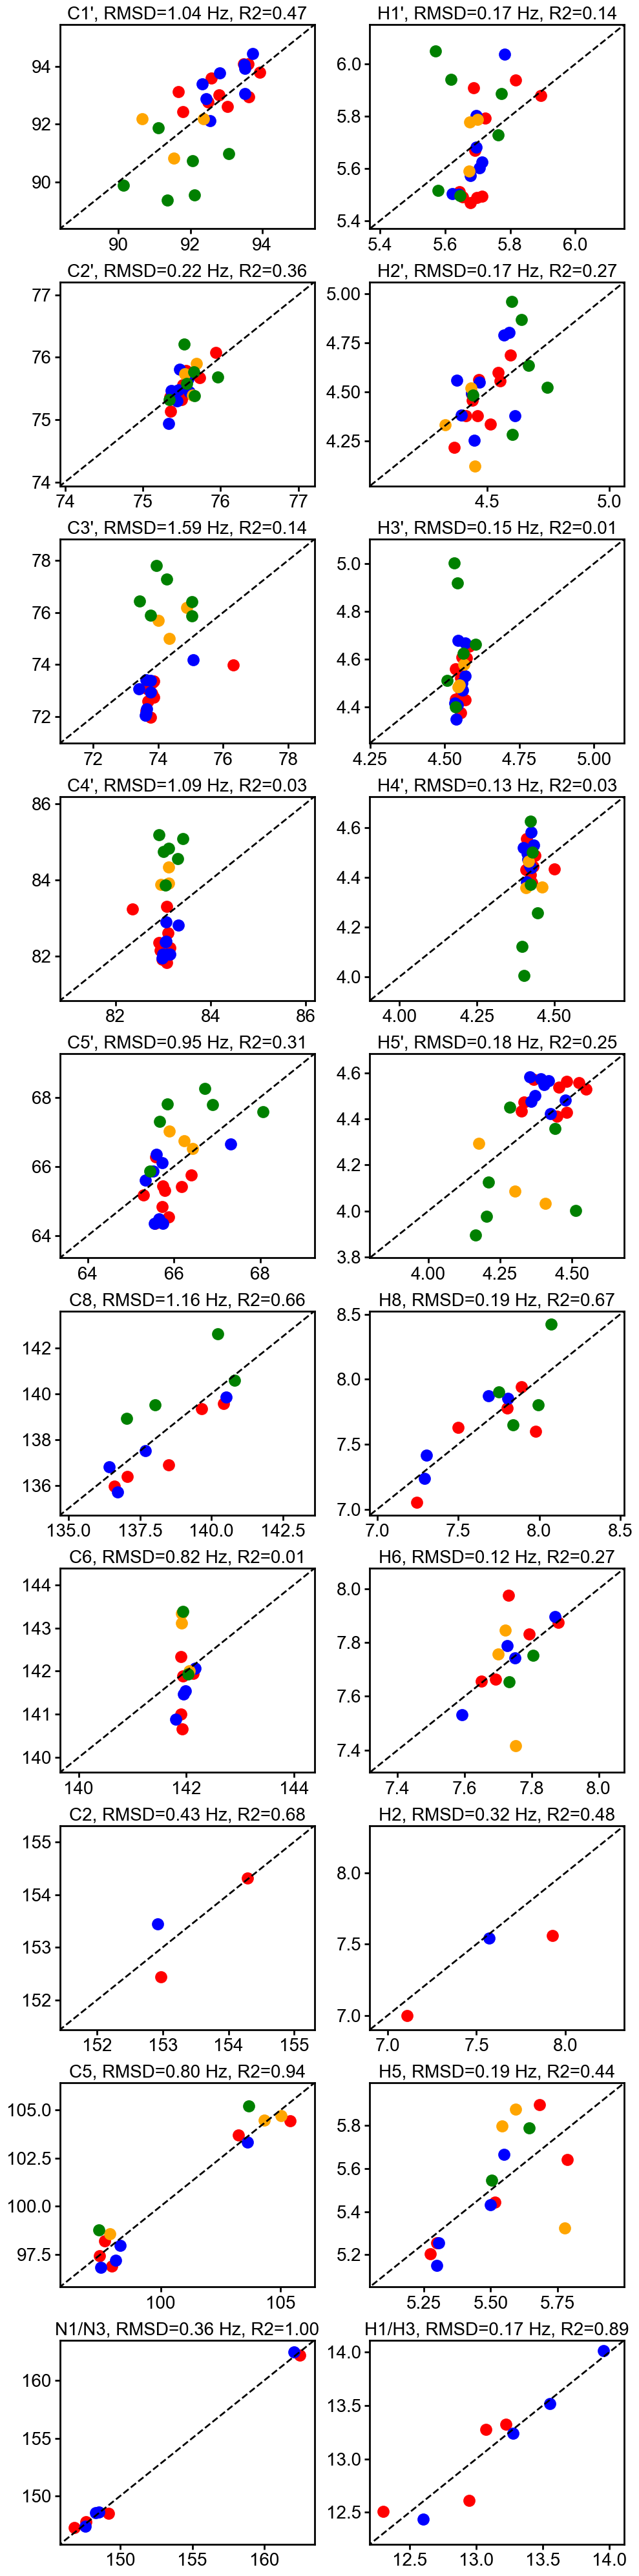

In [6]:
# FARFAR-lowest-energy (lowest rosetta energy score)

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/wtTAR_GS_ES1G34syn_Unbiased_LowestEnergy_DFT.csv").drop_duplicates()
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")


# Process & combine predicted & measured data
dfp['shift_ens_avg'] = np.nanmean(dfp.iloc[:,2:], axis=1)
dfp['shift_ens_std'] = np.nanstd(dfp.iloc[:,2:], axis=1)
dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
    'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
df = dfm.merge(dfp, on=["res", "atom"], how="inner")

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B', 'L']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L':'green'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    # Calculate linear correction:
    x = df.loc[filter1]["shift_ens_avg"]
    y = df.loc[filter1]["shift_nmr_avg"]
    m, b = np.polyfit(x, y, 1)   
    print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
    x_H = df.loc[filter2]["shift_ens_avg"]
    y_H = df.loc[filter2]["shift_nmr_avg"]
    m_H, b_H = np.polyfit(x_H, y_H, 1)   
    #print(resonance_H , ": y = %3.2f x + %3.2f"%(m_H, b_H))
    
    # Set up limits of axes
    lim_up = max(np.max(y), np.max(x*m+b)) + 1
    lim_down = min(np.min(y), np.min(x*m+b)) - 1
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    lim_up = max(np.max(y_H), np.max(x_H*m_H+b_H)) + 0.1
    lim_down = min(np.min(y_H), np.min(x_H*m_H+b_H)) - 0.1
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # Plot heavy atom:
        df_f = df.loc[(mask[domain]) & (filter1)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m * df_f.shift_ens_avg + b, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        # Plot proton associated with it:
        df_f = df.loc[(mask[domain]) & (filter2)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H * df_f.shift_ens_avg + b_H, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    x=np.array(x)
    y=np.array(y)
    x_H = np.array(x_H)
    y_H = np.array(y_H)
 
    R2 = calc_r2(m*x+b, y)
    RMSD = calc_rmsd(m*x+b, y)
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
    R2_H = calc_r2(m_H*x_H+b_H, y_H)
    RMSD_H = calc_rmsd(m_H*x_H+b_H, y_H)
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD_H, R2_H), fontsize=20)
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
#plt.savefig("plots/FARFAR_LowestEnergy_Ensemble_DFT.pdf")
plt.show()

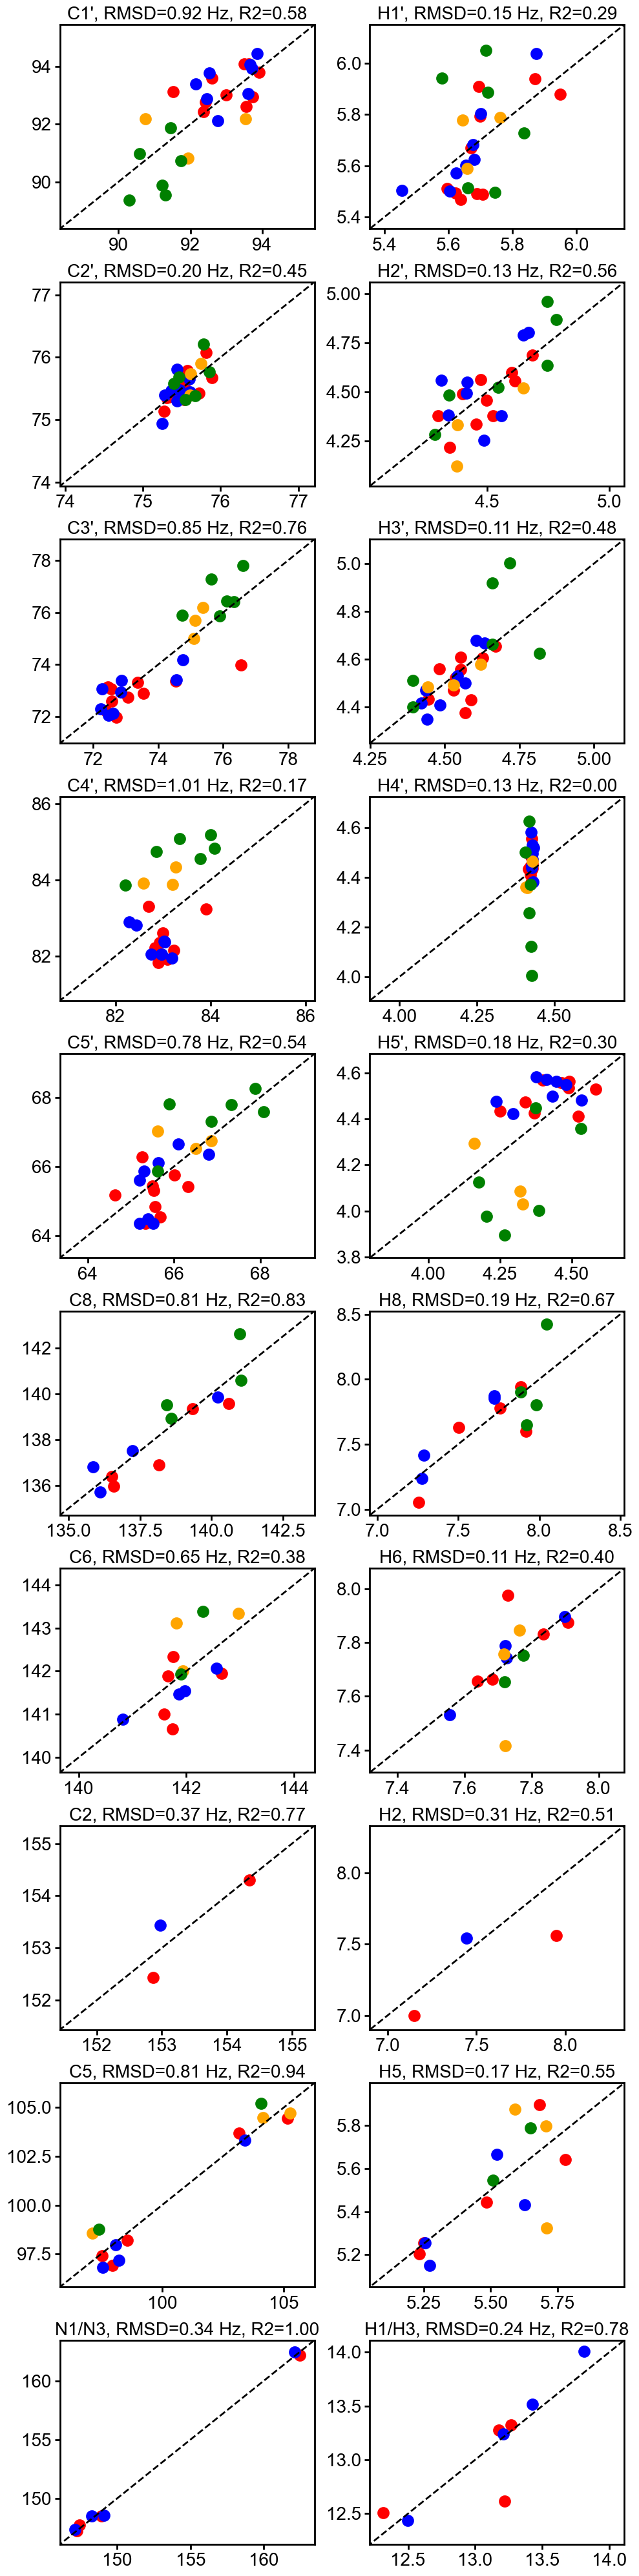

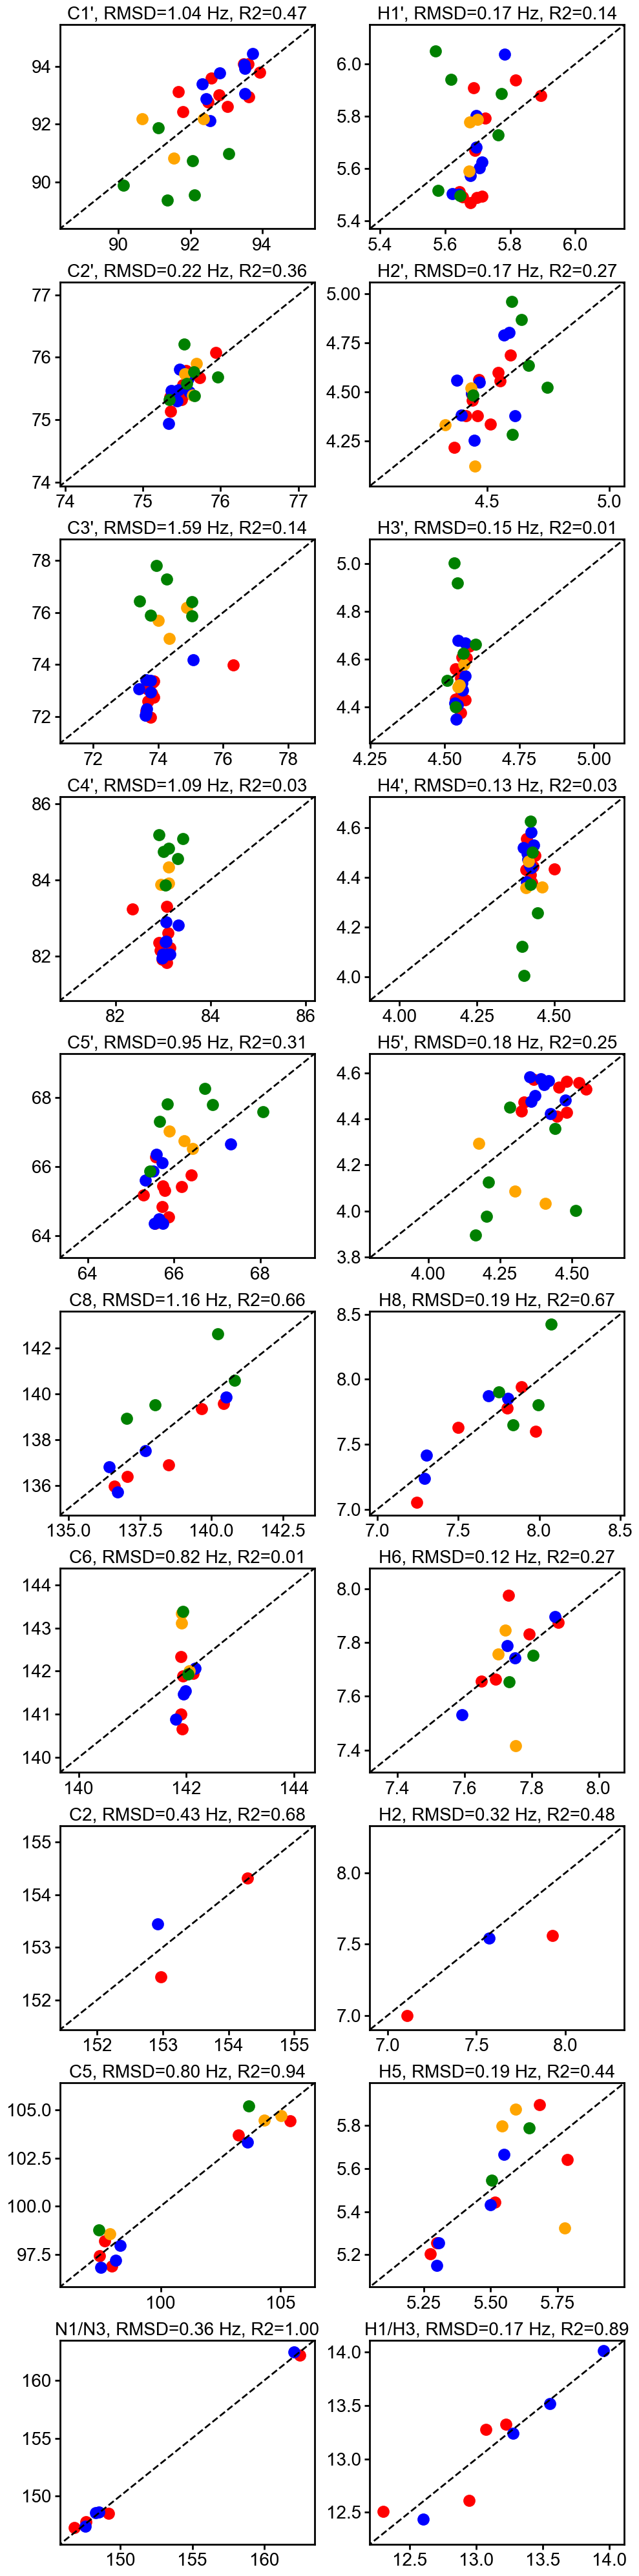

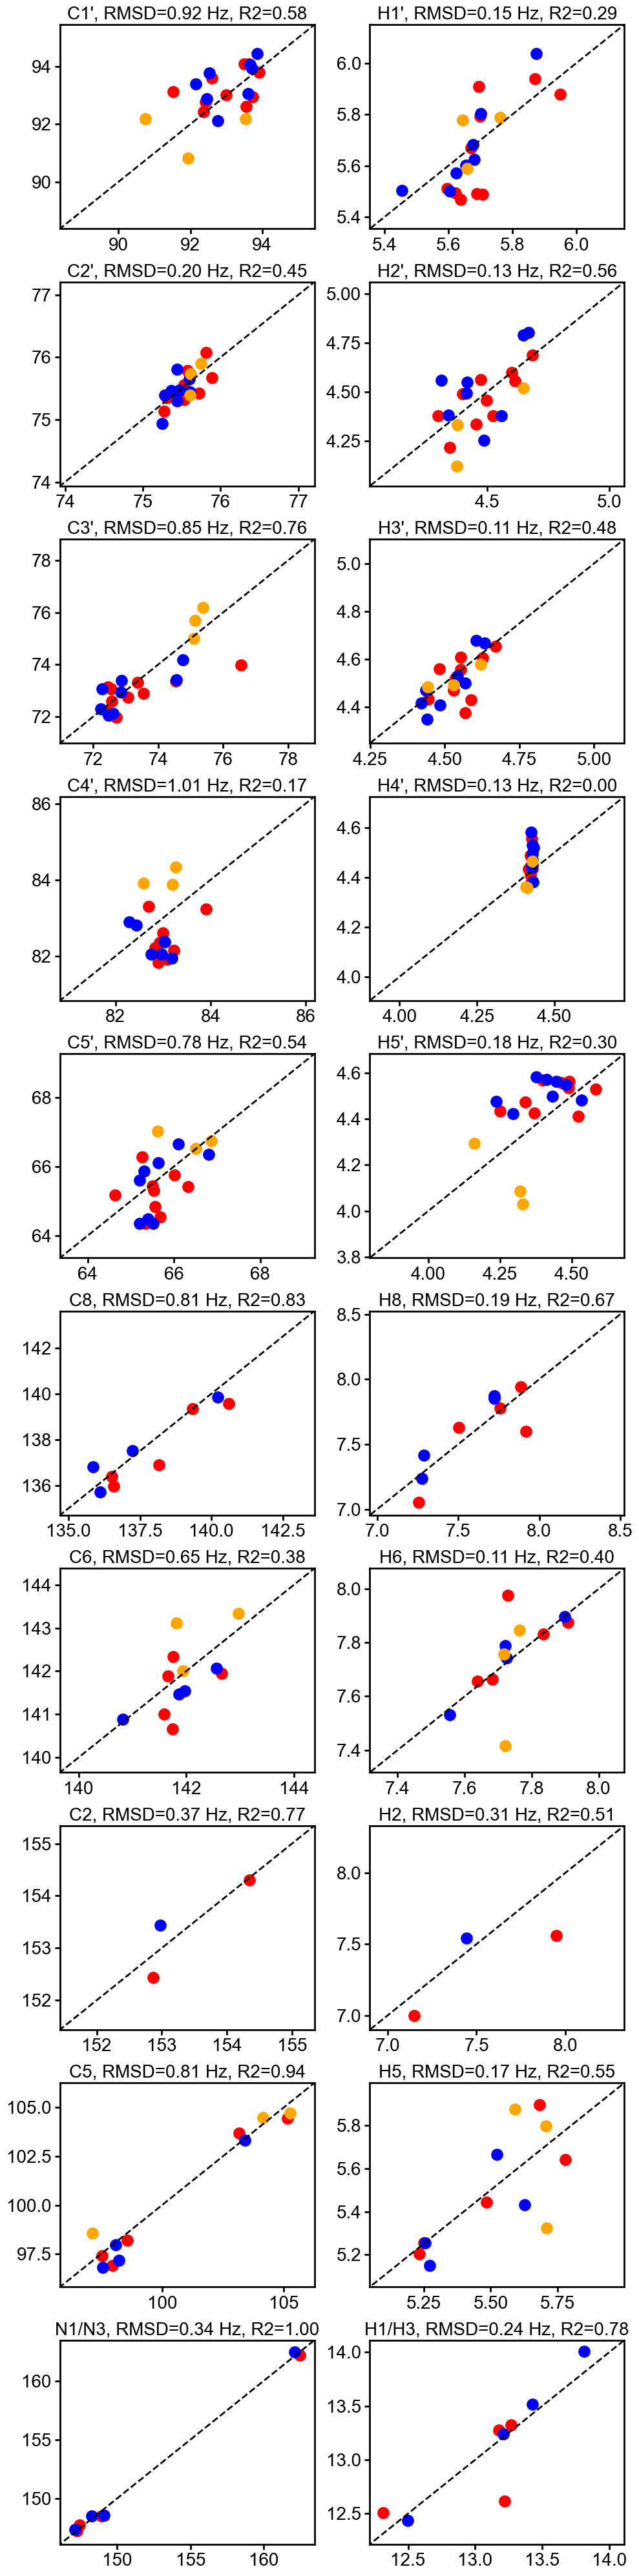

In [6]:
# FARFAR-NMR ensemble of mt-TAR (Honglue)
# Read in CSV data
dfp = pd.read_csv("data/FARFAR-wt-TAR-PoolRandom_predictedCS.csv").drop_duplicates()
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
dfp['shift_ens_avg'] = np.nanmean(dfp.iloc[:,2:], axis=1)
dfp['shift_ens_std'] = np.nanstd(dfp.iloc[:,2:], axis=1)
dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
    'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
df = dfm.merge(dfp, on=["res", "atom"], how="inner")

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    # Calculate linear correction:
    x = df.loc[filter1]["shift_ens_avg"]
    y = df.loc[filter1]["shift_nmr_avg"]
    m, b = np.polyfit(x, y, 1)   
    #print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
    x_H = df.loc[filter2]["shift_ens_avg"]
    y_H = df.loc[filter2]["shift_nmr_avg"]
    m_H, b_H = np.polyfit(x_H, y_H, 1)   
    #print(resonance_H , ": y = %3.2f x + %3.2f"%(m_H, b_H))
    
    # Set up limits of axes
    lim_up = max(np.max(y), np.max(x*m+b)) + 1
    lim_down = min(np.min(y), np.min(x*m+b)) - 1
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    lim_up = max(np.max(y_H), np.max(x_H*m_H+b_H)) + 0.1
    lim_down = min(np.min(y_H), np.min(x_H*m_H+b_H)) - 0.1
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # Plot heavy atom:
        df_f = df.loc[(mask[domain]) & (filter1)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m * df_f.shift_ens_avg + b, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        # Plot proton associated with it:
        df_f = df.loc[(mask[domain]) & (filter2)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H * df_f.shift_ens_avg + b_H, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    x=np.array(x)
    y=np.array(y)
    x_H = np.array(x_H)
    y_H = np.array(y_H)
 
    R2 = calc_r2(m*x+b, y)
    RMSD = calc_rmsd(m*x+b, y)
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
    R2_H = calc_r2(m_H*x_H+b_H, y_H)
    RMSD_H = calc_rmsd(m_H*x_H+b_H, y_H)
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD_H, R2_H), fontsize=20)
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
#plt.savefig("plots/Orca_Benchmark_FARFAR_NMR_Ens_HS.pdf")
plt.show()

In [6]:
########### PER CONFORMER ANALYSIS ################## 

In [3]:
# Compute R2 and RMSD per conformer

RMSD_ = []
CONF_ = []
RESONANCE_ = []
R2_ = []

for i in range(1, 21):
    print("CONFORMER ", i+1)
    # Read in CSV data
    dfp = pd.read_csv("data/Orca_DFT/wtTAR_GS_ES1G34syn_Unbiased_LowestRMSD_DFT.csv").drop_duplicates()
    dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

    # Process & combine predicted & measured data
    dfp['shift_ens_avg'] = dfp['shift_%i'%i]
    dfp['shift_ens_std'] = dfp['shift_%i'%i] * 0 # set to 0 
    dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
    dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
        'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
    df = dfm.merge(dfp, on=["res", "atom"], how="inner")

    # Define masks for TAR domains:
    mask = {}
    mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
    mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
    mask['B'] = df.res.isin([23, 24, 25])
    mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

    # Define resonances & TAR domains to plot:
    domains = ['H1', 'H2', 'B', 'L']
    domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L':'green'}
    resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
    N = len(resonances)

    # Prepare figure layout
    fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

    # Loop through diff. nuclei:
    for idx, resonance in enumerate(resonances):
        if resonance == "N1/N3":
            G_iminos = [18, 21, 26, 28, 36, 43]
            U_iminos = [38, 42]
            filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
            filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
            filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
            filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
            filter1 = filter_N1 | filter_N3
            filter2 = filter_H1 | filter_H3
            resonance_H = "H1/H3"
            #print(df.loc[filter1])
        else:
            filter1 = (df["atom"] == resonance)
            resonance_H = "H" + resonance[1:]
            filter2 = (df["atom"] == resonance_H)
    
        # Calculate linear correction:
        x = df.loc[filter1]["shift_ens_avg"]
        y = df.loc[filter1]["shift_nmr_avg"]
        m, b = np.polyfit(x, y, 1)   
        #print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
        x_H = df.loc[filter2]["shift_ens_avg"]
        y_H = df.loc[filter2]["shift_nmr_avg"]
        m_H, b_H = np.polyfit(x_H, y_H, 1)   
        #print(resonance_H , ": y = %3.2f x + %3.2f"%(m_H, b_H))
    
        # Set up limits of axes
        lim_up = max(np.max(y), np.max(x*m+b)) + 1
        lim_down = min(np.min(y), np.min(x*m+b)) - 1
        axs[idx, 0].set_xlim([lim_down, lim_up])
        axs[idx, 0].set_ylim([lim_down, lim_up])
        lim_up = max(np.max(y_H), np.max(x_H*m_H+b_H)) + 0.1
        lim_down = min(np.min(y_H), np.min(x_H*m_H+b_H)) - 0.1
        axs[idx, 1].set_xlim([lim_down, lim_up])
        axs[idx, 1].set_ylim([lim_down, lim_up])
    
        for domain in domains:
            # Plot heavy atom:
            df_f = df.loc[(mask[domain]) & (filter1)]
            if df_f.shape[0] == 0:
                continue
            else:
                col = domain_cols[domain]
                axs[idx, 0].plot( m * df_f.shift_ens_avg + b, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
            # Plot proton associated with it:
            df_f = df.loc[(mask[domain]) & (filter2)]
            if df_f.shape[0] == 0:
                continue
            else:
                col = domain_cols[domain]
                axs[idx, 1].plot( m_H * df_f.shift_ens_avg + b_H, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
        axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
        axs[idx, 0].tick_params(width=2,length=6)
        axs[idx, 1].tick_params(width=2,length=6)
    
        x=np.array(x)
        y=np.array(y)
        x_H = np.array(x_H)
        y_H = np.array(y_H)
 
        R2 = calc_r2(m*x+b, y)
        RMSD = calc_rmsd(m*x+b, y)
        axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
        R2_H = calc_r2(m_H*x_H+b_H, y_H)
        RMSD_H = calc_rmsd(m_H*x_H+b_H, y_H)
        axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD_H, R2_H), fontsize=20)
        axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
        axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)
        
        CONF_.append(i)
        RMSD_.append(RMSD)
        R2_.append(R2)
        RESONANCE_.append(resonance)
        
        CONF_.append(i)
        RMSD_.append(RMSD_H)
        R2_.append(R2_H)
        RESONANCE_.append(resonance_H)
        
        fig.tight_layout()
        plt.savefig("plots/CS_per_conf/FARFAR_NMR_conf_%d.pdf"%i)

df = pd.DataFrame()
df["conf"] = CONF_
df["resonance"] = RESONANCE_
df["rmsd"] = RMSD_
df["r2"] = R2_

print(df.head())

CONFORMER  2
CONFORMER  3
CONFORMER  4
CONFORMER  5
CONFORMER  6
CONFORMER  7
CONFORMER  8
CONFORMER  9
CONFORMER  10
CONFORMER  11
CONFORMER  12
CONFORMER  13
CONFORMER  14
CONFORMER  15
CONFORMER  16
CONFORMER  17
CONFORMER  18
CONFORMER  19
CONFORMER  20
CONFORMER  21
   conf resonance      rmsd        r2
0     1       C1'  1.360725  0.082416
1     1       H1'  0.168387  0.163506
2     1       C2'  0.243652  0.202270
3     1       H2'  0.172268  0.237967
4     1       C3'  1.389790  0.348463


In [17]:
print(df)

     conf resonance      rmsd        r2
0       1       C1'  1.360725  0.082416
1       1       H1'  0.168387  0.163506
2       1       C2'  0.243652  0.202270
3       1       H2'  0.172268  0.237967
4       1       C3'  1.389790  0.348463
..    ...       ...       ...       ...
395    20        H2  0.323187  0.453329
396    20        C5  0.846801  0.935081
397    20        H5  0.179446  0.488495
398    20     N1/N3  0.339379  0.997016
399    20     H1/H3  0.215781  0.824696

[400 rows x 4 columns]


In [9]:
# Print average statistics from above

df_heavy = df.loc[df.resonance.isin(["C1'", "C2'", "C3'", "C4'", "C5'", "C6", "C8", "C2", "C5"])]
df_H = df.loc[df.resonance.isin(["H1'", "H2'", "H3'", "H4'", "H5'", "H6", "H8", "H2", "H5"])]
print("Heavy atom:")
print(np.mean(df_heavy.rmsd))
print(np.mean(df_heavy.r2))

print("Protons:")
print(np.mean(df_H.rmsd))
print(np.mean(df_H.r2))

Heavy atom:
0.9369774565749658
0.3705405939298116
Protons:
0.17175855972613924
0.3023545285822592


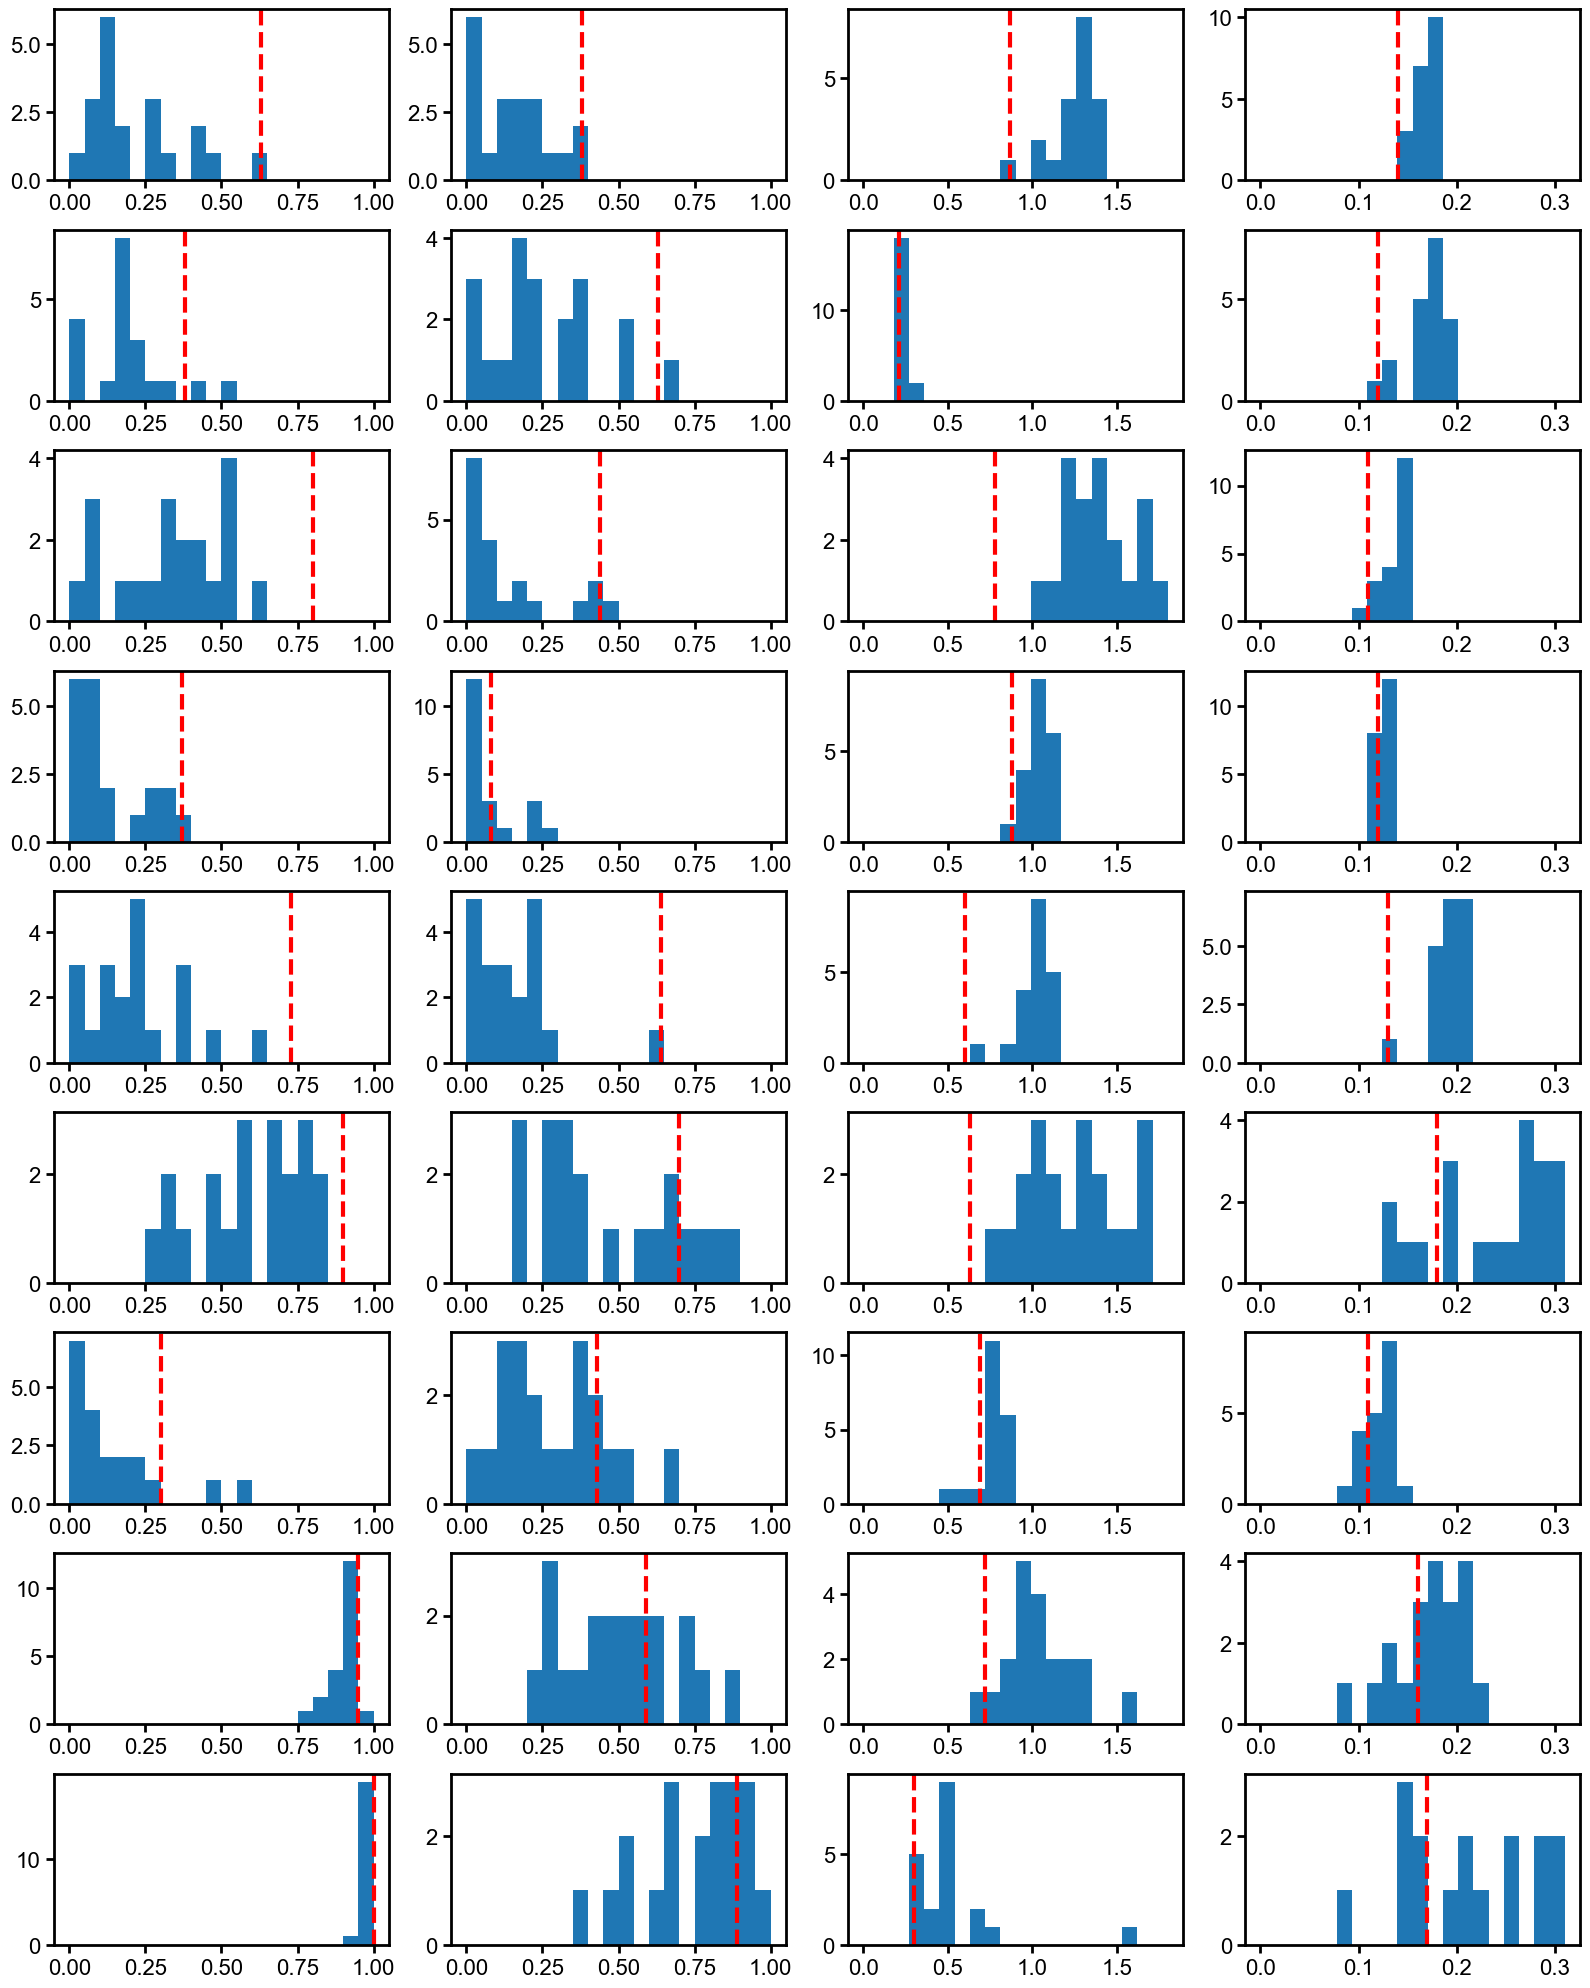

In [7]:
# Plot distribution of R2 and RMSD for each conformer against the ensemble average:

plt.close()
fig, axs = plt.subplots(9, 4, figsize=(16,20))
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C5", "N1/N3"]
resonancesH = ["H1'", "H2'", "H3'", "H4'", "H5'", "H8", "H6", "H5", "H1/H3"]

r2_ens_C = [0.63, 0.38, 0.80, 0.37, 0.73, 0.9, 0.3, 0.95, 1]
r2_ens_H = [0.38, 0.63, 0.44, 0.08, 0.64, 0.7, 0.43, 0.59, 0.89]
rmsd_ens_C = [0.87, 0.21, 0.78, 0.88, 0.60, 0.63, 0.69, 0.72, 0.3]
rmsd_ens_H = [0.14, 0.12, 0.11, 0.12, 0.13, 0.18, 0.11, 0.16, 0.17]

for i in range(len(resonances)):
    Cres = resonances[i]
    Hres = resonancesH[i]
    conditionC = (df.resonance == Cres)
    conditionH = (df.resonance == Hres)
    
    cdata_r2 = df.loc[conditionC, "r2"]
    hdata_r2 = df.loc[conditionH, "r2"]
    cdata_rmsd = df.loc[conditionC, "rmsd"]
    hdata_rmsd = df.loc[conditionH, "rmsd"]
    
    # Plot RMSD:
    axs[i, 0].hist(cdata_r2, bins=20, range=(0, 1))
    axs[i, 1].hist(hdata_r2, bins=20, range=(0, 1))
    axs[i, 2].hist(cdata_rmsd, bins=20, range=(0, 1.8))
    axs[i, 3].hist(hdata_rmsd, bins=20, range=(0, 0.31))
    
    for j in range(4):
        axs[i, j].tick_params(width=2,length=6, labelsize=16)
    
    axs[i, 0].axvline(r2_ens_C[i], color="red", ls="--", lw=3)
    axs[i, 1].axvline(r2_ens_H[i], color="red", ls="--", lw=3)
    axs[i, 2].axvline(rmsd_ens_C[i], color="red", ls="--", lw=3)
    axs[i, 3].axvline(rmsd_ens_H[i], color="red", ls="--", lw=3)
fig.tight_layout()
plt.savefig("r2_rmsd_per_conf.pdf")
plt.show()